Modified copy of the Notebook from the excellent tutorial by [angioi](https://www.angioi.com/dog-breed-classification/)

#Imports + Data Loading

In [1]:
%tensorflow_version 2.x

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete3GH2CE/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete3GH2CE/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


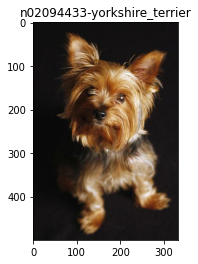

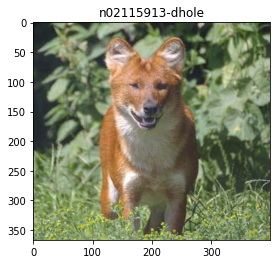

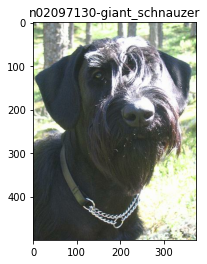

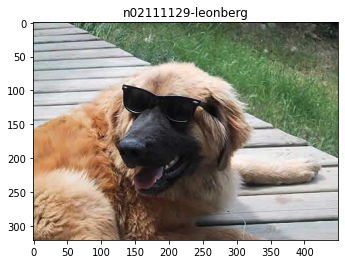

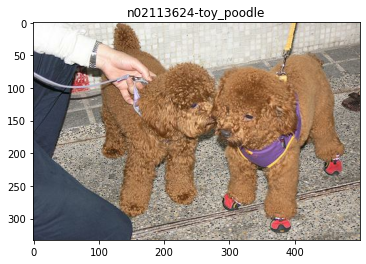

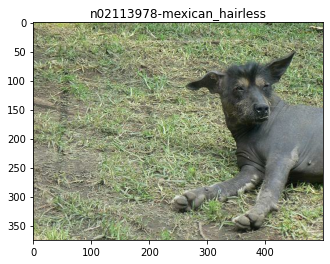

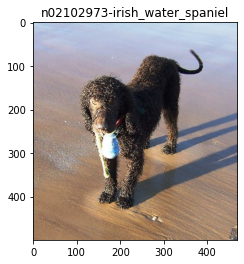

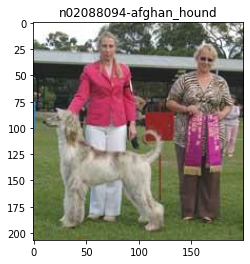

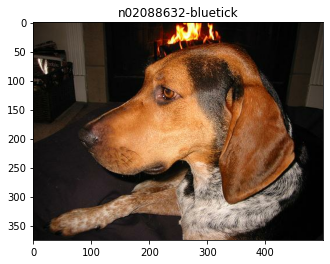

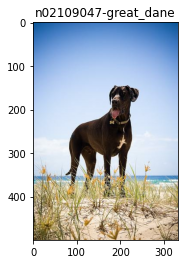

In [3]:
get_name = info.features['label'].int2str

for doggo in dataset['train'].take(10):
  plt.figure()
  plt.imshow(doggo['image'])
  plt.title(get_name(doggo['label']))

In [4]:
IMG_LEN = 224
IMG_SHAPE = (IMG_LEN,IMG_LEN,3)
N_BREEDS = 120

training_data = dataset['train']
test_data = dataset['test']

def preprocess(ds_row):
  
  # Image conversion int->float + resizing
  image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
  image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  
  # Onehot encoding labels
  label = tf.one_hot(ds_row['label'],N_BREEDS)

  return image, label

def prepare(dataset, batch_size=None):
  ds = dataset.map(preprocess, num_parallel_calls=4)
  ds = ds.shuffle(buffer_size=1000)
  if batch_size:
    ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

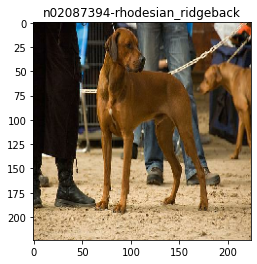

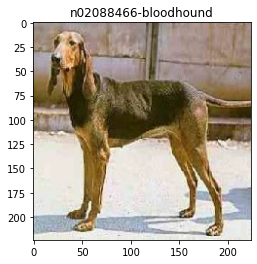

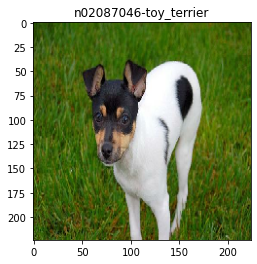

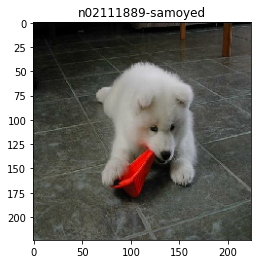

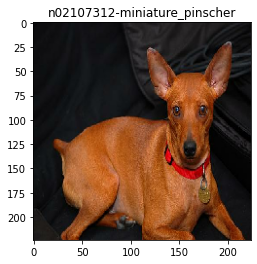

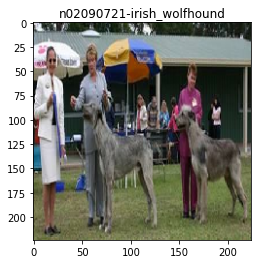

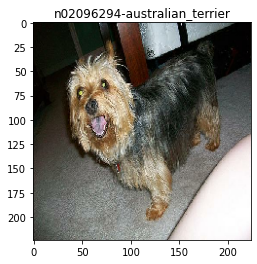

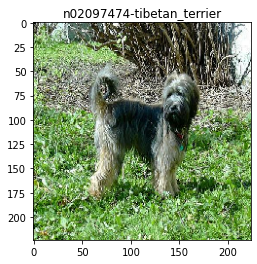

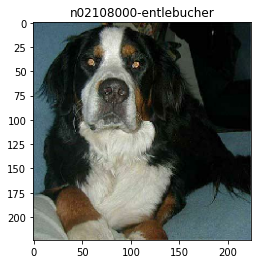

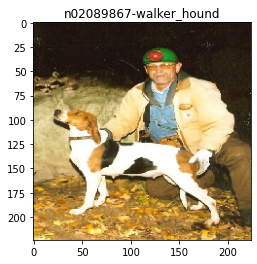

In [5]:
decode = lambda x: get_name(tf.math.argmax(x))

for pic, label in prepare(training_data).take(10):
  plt.figure()
  plt.imshow(pic)
  plt.title(decode(label))

# Model building + Training

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(N_BREEDS, activation='softmax')
])

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
train_batches = prepare(training_data, batch_size=32)
test_batches = prepare(test_data, batch_size=32)

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=test_batches)


Epoch 1/30
375/375 [==============================] - 79s 177ms/step - loss: 4.6319 - accuracy: 0.0405 - top_k_categorical_accuracy: 0.1413 - val_loss: 4.3013 - val_accuracy: 0.0760 - val_top_k_categorical_accuracy: 0.2488
Epoch 2/30
375/375 [==============================] - 70s 181ms/step - loss: 4.0603 - accuracy: 0.1241 - top_k_categorical_accuracy: 0.3448 - val_loss: 3.8567 - val_accuracy: 0.1720 - val_top_k_categorical_accuracy: 0.4483
Epoch 3/30
375/375 [==============================] - 71s 183ms/step - loss: 3.6335 - accuracy: 0.2240 - top_k_categorical_accuracy: 0.5351 - val_loss: 3.4720 - val_accuracy: 0.2718 - val_top_k_categorical_accuracy: 0.6064
Epoch 4/30
375/375 [==============================] - 69s 177ms/step - loss: 3.2627 - accuracy: 0.3199 - top_k_categorical_accuracy: 0.6818 - val_loss: 3.1391 - val_accuracy: 0.3571 - val_top_k_categorical_accuracy: 0.7148
Epoch 5/30
375/375 [==============================] - 69s 176ms/step - loss: 2.9409 - accuracy: 0.4045 - top

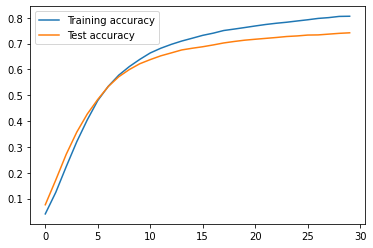

In [11]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend();

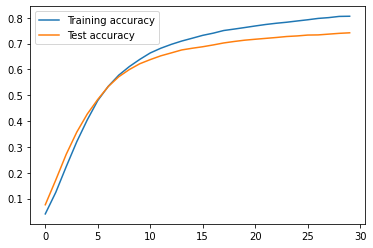

In [12]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend()
plt.savefig('lc.svg')

# Random doggos from the internet

In [13]:
filename_dataset = tf.data.Dataset.list_files("Doggos/*.jp*g")
image_dataset = filename_dataset.map(lambda x: tf.io.decode_jpeg(tf.io.read_file(x)))

for dog in image_dataset:

  mock_dict = {'image': dog, 'label': 0}
  pic, _ = preprocess(mock_dict)

  plt.figure()
  plt.imshow(pic)

  img_tensor = tf.expand_dims(pic,0)
  pred = model(img_tensor)
  
  top_components = tf.reshape(tf.math.top_k(pred, k=5).indices,shape=[-1])
  print(top_components)
  top_matches = [get_name(i) for i in top_components]

  plt.title(top_matches[0])
  print(top_matches)



InvalidArgumentError: ignored

In [14]:
# Save model
!mkdir -p saved_model
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [17]:
# Convert Keras model into one TensorflowJS can consume
!mkdir -p converted_model
!pip install tensorflowjs[wizard]
!tensorflowjs_converter --input_format="keras_saved_model" /content/saved_model /content/output/converted_model

2022-01-24 02:01:20.797092: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [18]:
# Generate label file
import json

label = info.features['label'].save_metadata('./')

data = []

for i in range(N_BREEDS):
    data.append(get_name(i))

json_object = json.dumps(data, indent=4)

with open("output/dog_labels.json", "w") as outfile:
    outfile.write(json_object)

In [19]:
# Zip files for download
!zip -r /content/DogModel.zip /content/output

  adding: content/output/ (stored 0%)
  adding: content/output/dog_labels.json (deflated 65%)
  adding: content/output/converted_model/ (stored 0%)
  adding: content/output/converted_model/group1-shard1of3.bin (deflated 7%)
  adding: content/output/converted_model/model.json (deflated 96%)
  adding: content/output/converted_model/group1-shard3of3.bin (deflated 7%)
  adding: content/output/converted_model/group1-shard2of3.bin (deflated 7%)
